# 0.Import Libraries

In [ ]:
!pip install shap

In [10]:
!pip install imblearn mlxtend

In [11]:
import os
import warnings
from warnings import simplefilter
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'white')

import shap
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# 1.Load Dataset

In [12]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2.Data Analysis

In [13]:
def create_analysis_dataframe(dataset):
    list=[]
    for column in dataset.columns:
        data_type=dataset.dtypes[column]
        unique_number=dataset[column].unique().size
        null_ratio=dataset[column].isnull().sum()/dataset.shape[0]
        most_frequent_value= dataset[column].value_counts().idxmax()
        least_frequent_value= dataset[column].value_counts().idxmin()
        list.append([column,data_type,unique_number,null_ratio,most_frequent_value,least_frequent_value])
    dataset_info=pd.DataFrame(list,columns=['Name',
                                            'Data_Type',
                                            'Unique_Size',
                                            'Null_Ratio',
                                            'Most_Frequent_Value',
                                            'Least_Frequent_Value']).sort_values(by=['Unique_Size','Name'],
                                                                                 ascending=True)
    return dataset_info

dataset_info=create_analysis_dataframe(data)
dataset_info

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value
20,Churn,object,2,0.0,No,Yes
4,Dependents,object,2,0.0,No,Yes
16,PaperlessBilling,object,2,0.0,Yes,No
3,Partner,object,2,0.0,No,Yes
6,PhoneService,object,2,0.0,Yes,No
2,SeniorCitizen,int64,2,0.0,0,1
1,gender,object,2,0.0,Male,Female
15,Contract,object,3,0.0,Month-to-month,One year
11,DeviceProtection,object,3,0.0,No,No internet service
8,InternetService,object,3,0.0,Fiber optic,No


## 2.1 Total Charges
First I want to start by setting the index.

In the previous cell, I realize that even though **"TotalCharges"** has numbers as value but type of the column is **'object'**.

Also, since the most frequently used value is **empty space**, my second move will be to change this column type and also its most frequently used value.

In [14]:
data.set_index('customerID', inplace=True)

In [15]:
data['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [16]:
data['TotalCharges'] = data['TotalCharges'].replace(' ','0')
data['TotalCharges'] = data['TotalCharges'].astype('float')

In [17]:
data['TotalCharges'].astype('float')

customerID
7590-VHVEG      29.85
5575-GNVDE    1889.50
3668-QPYBK     108.15
7795-CFOCW    1840.75
9237-HQITU     151.65
               ...   
6840-RESVB    1990.50
2234-XADUH    7362.90
4801-JZAZL     346.45
8361-LTMKD     306.60
3186-AJIEK    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [18]:
dataset_info=create_analysis_dataframe(data)
dataset_info

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value
19,Churn,object,2,0.0,No,Yes
3,Dependents,object,2,0.0,No,Yes
15,PaperlessBilling,object,2,0.0,Yes,No
2,Partner,object,2,0.0,No,Yes
5,PhoneService,object,2,0.0,Yes,No
1,SeniorCitizen,int64,2,0.0,0,1
0,gender,object,2,0.0,Male,Female
14,Contract,object,3,0.0,Month-to-month,One year
10,DeviceProtection,object,3,0.0,No,No internet service
7,InternetService,object,3,0.0,Fiber optic,No


## 2.2 Visualization

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16608\400098976.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


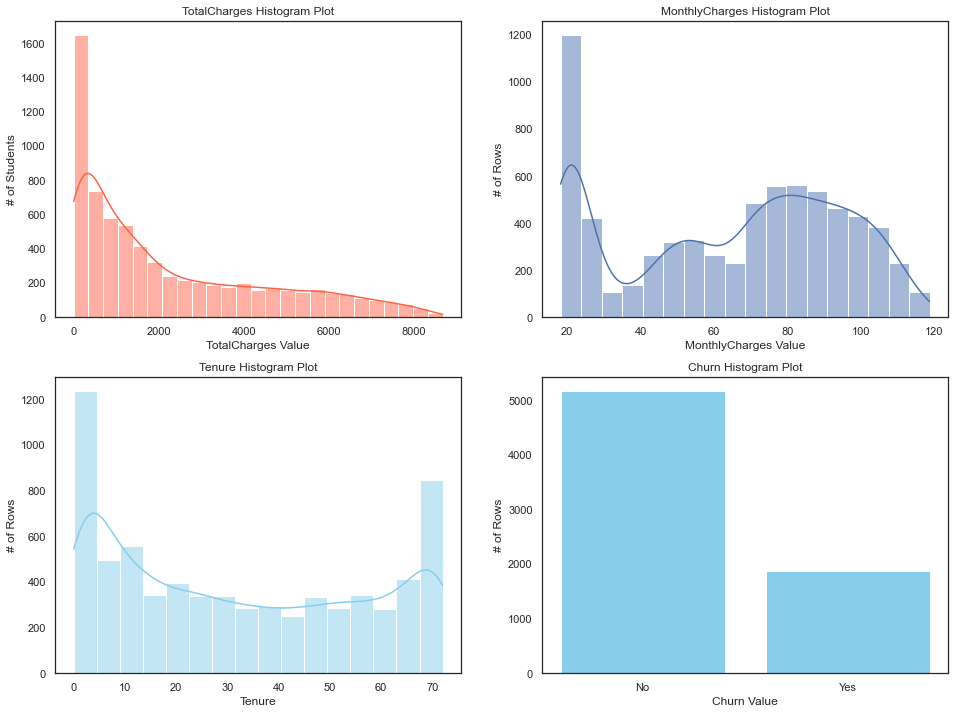

In [19]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2,
                                          nrows=2,
                                          figsize=(16,12))

#  TotalCharges
sns.histplot(data['TotalCharges'],kde=True,ax =ax0, color='tomato')
ax0.set_title('TotalCharges Histogram Plot')
ax0.set_xlabel('TotalCharges Value')
ax0.set_ylabel('# of Students')

# MonthlyCharges 
sns.histplot(data['MonthlyCharges'],kde=True,ax =ax1)
ax1.set_title('MonthlyCharges Histogram Plot')
ax1.set_xlabel('MonthlyCharges Value')
ax1.set_ylabel('# of Rows')

# Churn 
sns.histplot(data['tenure'],kde=True,ax =ax2,color='skyblue')
ax2.set_title('Tenure Histogram Plot')
ax2.set_xlabel('Tenure')
ax2.set_ylabel('# of Rows')

# gre 
ax3.bar(x = data['Churn'].value_counts().keys(),
        height = data['Churn'].value_counts().values,
        color ='skyblue')
ax3.set_title('Churn Histogram Plot')
ax3.set_xlabel('Churn Value')
ax3.set_ylabel('# of Rows')


fig.show()

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

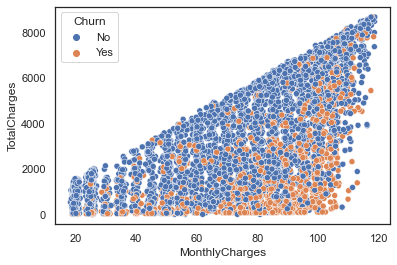

In [20]:
sns.scatterplot(data=data,x='MonthlyCharges',y='TotalCharges',hue='Churn')

<AxesSubplot:xlabel='TotalCharges', ylabel='tenure'>

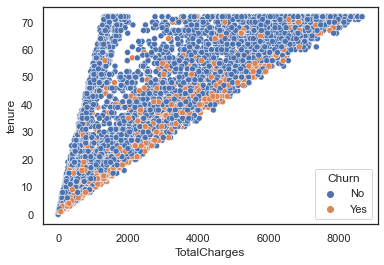

In [21]:
sns.scatterplot(data=data,x='TotalCharges',y='tenure',hue='Churn')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16608\762569615.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


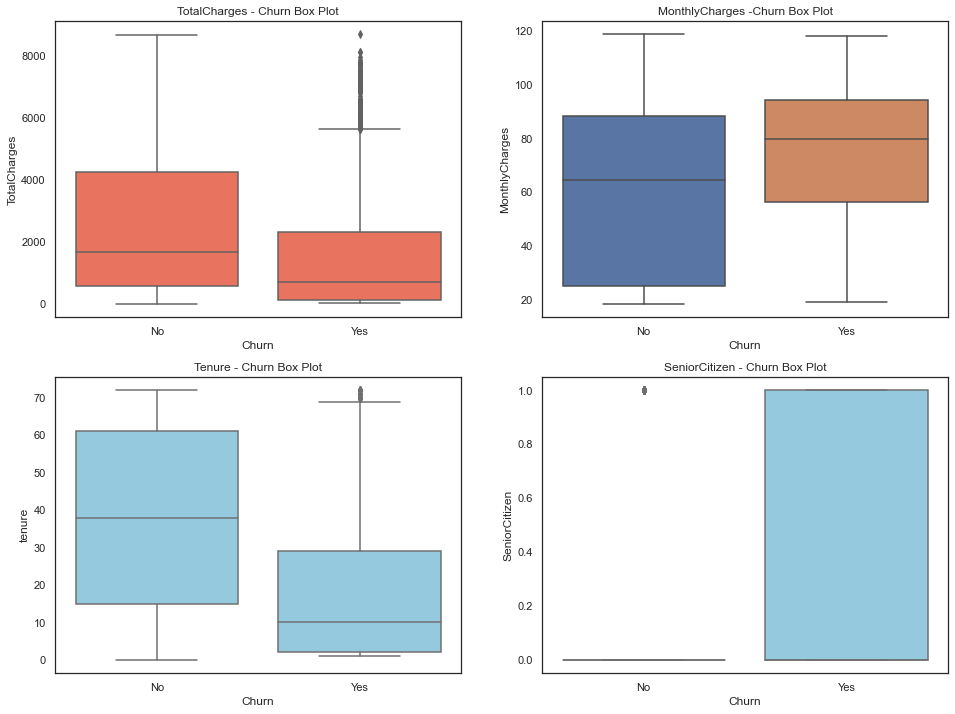

In [22]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2,
                                          nrows=2,
                                          figsize=(16,12))

#  TotalCharges
sns.boxplot(x='Churn',
            y='TotalCharges',
            data = data,
            ax =ax0, color='tomato')
ax0.set_title('TotalCharges - Churn Box Plot')

# MonthlyCharges 
sns.boxplot(x='Churn',
            y='MonthlyCharges',
            data = data,
            ax =ax1)
ax1.set_title('MonthlyCharges -Churn Box Plot')

# Churn 
sns.boxplot(x='Churn',
            y='tenure',
            data = data,
            ax =ax2, color='skyblue')
ax2.set_title('Tenure - Churn Box Plot')

# SeniorCitizen 
sns.boxplot(x='Churn',
            y='SeniorCitizen',
            data = data,
            ax =ax3, color='skyblue')
ax3.set_title('SeniorCitizen - Churn Box Plot')


fig.show()

## 2.3 Statistical Analysis

In [23]:
object_columns = data.select_dtypes(include='object').columns.tolist()
len(object_columns)

16

# 3.Data Preprocessing

## 3.1 Columns with only 2 unique values
My next step will be to encode the columns that only have 2 unique labels and those labels are 'No' or 'Yes'.

In [24]:
column_list =['Churn',
              'Dependents',
              'PaperlessBilling',
              'Partner',
              'PhoneService']

for each in column_list:
    data[each] = np.where(data[each]=='No', 0, 1)
    
dataset_info=create_analysis_dataframe(data)
dataset_info

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value
19,Churn,int32,2,0.0,0,1
3,Dependents,int32,2,0.0,0,1
15,PaperlessBilling,int32,2,0.0,1,0
2,Partner,int32,2,0.0,0,1
5,PhoneService,int32,2,0.0,1,0
1,SeniorCitizen,int64,2,0.0,0,1
0,gender,object,2,0.0,Male,Female
14,Contract,object,3,0.0,Month-to-month,One year
10,DeviceProtection,object,3,0.0,No,No internet service
7,InternetService,object,3,0.0,Fiber optic,No


## 3.2 Encoding the remaining Categorical columns
Because of **Multicollinearity** in the dataset, when I use one-hot encoding , I will drop first column.

In [25]:
data = pd.get_dummies(data,  dtype=int, drop_first=True)

dataset_info=create_analysis_dataframe(data)
dataset_info

,Name,Data_Type,Unique_Size,Null_Ratio,Most_Frequent_Value,Least_Frequent_Value
8,Churn,int32,2,0.0,0.00,1.00
26,Contract_One year,int32,2,0.0,0.00,1.00
27,Contract_Two year,int32,2,0.0,0.00,1.00
2,Dependents,int32,2,0.0,0.00,1.00
18,DeviceProtection_No internet service,int32,2,0.0,0.00,1.00
19,DeviceProtection_Yes,int32,2,0.0,0.00,1.00
12,InternetService_Fiber optic,int32,2,0.0,0.00,1.00
13,InternetService_No,int32,2,0.0,0.00,1.00
10,MultipleLines_No phone service,int32,2,0.0,0.00,1.00
11,MultipleLines_Yes,int32,2,0.0,0.00,1.00


## 3.3 Multicollinearity
**We have multicollinearity in our data, so we should models which are less sensitive to multicollinearity.**

In [26]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by=['VIF'],
                          ascending=False)
    return(vif)

X = data.drop('Churn',axis=1)
calc_vif(X)

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
15,OnlineBackup_No internet service,inf
12,InternetService_No,inf
19,TechSupport_No internet service,inf
17,DeviceProtection_No internet service,inf
23,StreamingMovies_No internet service,inf
13,OnlineSecurity_No internet service,inf
21,StreamingTV_No internet service,inf
4,PhoneService,1770.644580
6,MonthlyCharges,865.062147
11,InternetService_Fiber optic,148.263380


## 3.4 Correlation

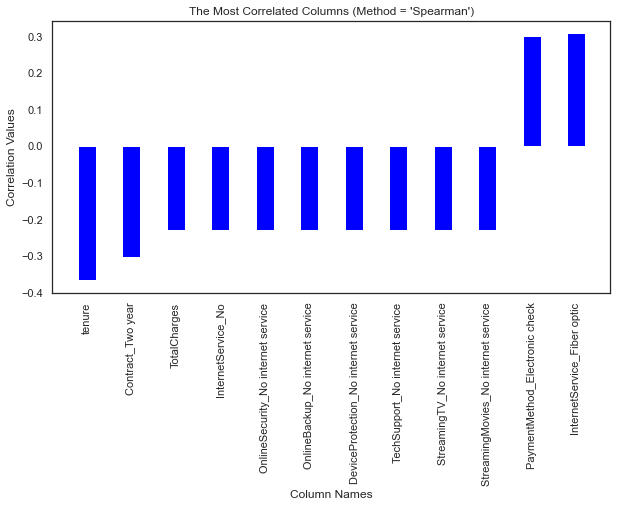

In [27]:
spearman_corr = data.corr(method='spearman').drop('Churn',axis=0)
most_correlated_spearman = spearman_corr.loc[(spearman_corr['Churn']>0.2) | (spearman_corr['Churn'] < -0.2)][['Churn']].sort_values('Churn')
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(x = most_correlated_spearman.index,
        height=most_correlated_spearman['Churn'],
        color ='blue', 
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Column Names")
plt.ylabel("Correlation Values")
plt.title("The Most Correlated Columns (Method = 'Spearman')")
plt.show()

## 3.5 Train-Test Split

In [28]:
np.random.seed(123)
features = data.drop(['Churn'],axis=1).reset_index(drop=True)
label = data['Churn'].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.33, random_state=42,stratify=label)

In [29]:
features.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Male,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,34,1,0,56.95,1889.50,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,2,1,1,53.85,108.15,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,45,0,0,42.30,1840.75,1,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,2,1,1,70.70,151.65,0,0,...,0,0,0,0,0,0,0,0,1,0


## 3.6 Standardization

In [30]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features.columns, index=y_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features.columns, index=y_test.index)

# 4.Base Models
## 4.1 Logistic Regression

Accuracy : 0.7995698924731183 F1 Score : 0.5854092526690392 


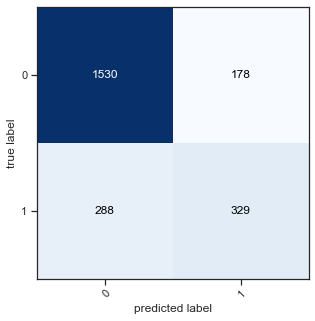

In [31]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
lg_preds = lg_model.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, lg_preds)} F1 Score : {f1_score(y_test, lg_preds)} ")

result=confusion_matrix(y_test,lg_preds)
plot_confusion_matrix(conf_mat=result,figsize=(5,5),class_names=np.unique(y_test))
plt.show()

## 4.2 Xgboost

In [32]:
# Assuming class 0 is the negative class and class 1 is the positive class
neg, pos = np.bincount(y_train)  # y_train is the target variable
scale_pos_weight = neg / pos

C:\Users\ASUS\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


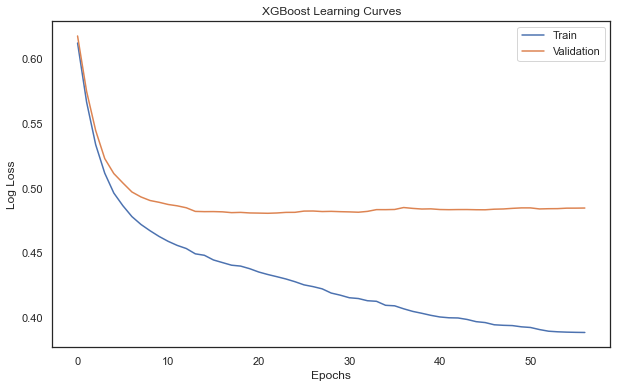

In [33]:
xg_model = XGBClassifier(max_depth=4,
                         min_child_weight=3.50,
                         subsample=1,
                         colsample_bytree=0.73,
                         reg_alpha=0.0,
                         reg_lambda =0.5,
                        n_estimators=57,
                       scale_pos_weight=scale_pos_weight)

# Train the XGBoost model with early stopping to capture the learning curve
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Extract results from evaluation history
results = xg_model.evals_result()

# Plot learning curves
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.show()

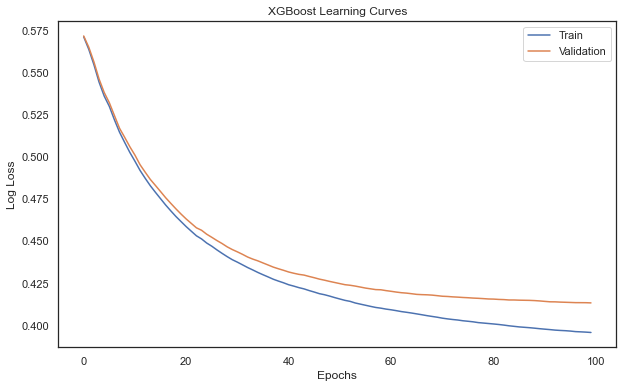

In [34]:
xgb_model = XGBClassifier(
    max_depth=3,            
    min_child_weight=5,     
    subsample=0.8,          
    colsample_bytree=0.6,   
    reg_alpha=0.1,          
    reg_lambda=1.0,         
    n_estimators=100,       
    learning_rate=0.05,
#     scale_pos_weight=scale_pos_weight
)

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Extract results from evaluation history
results = xgb_model.evals_result()

# Plot learning curves
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.show()

Accuracy train : 0.8021505376344086 F1 Score train : 0.5708955223880597 


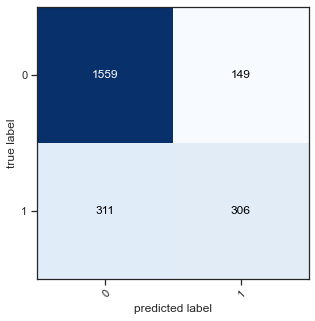

In [35]:
prediction = xgb_model.predict(X_test)
print(f"Accuracy train : {accuracy_score(y_test,prediction)} F1 Score train : {f1_score(y_test, prediction)} ")

result=confusion_matrix(y_test,prediction)
plot_confusion_matrix(conf_mat=result,figsize=(5,5),class_names=np.unique(y_test))
plt.show()

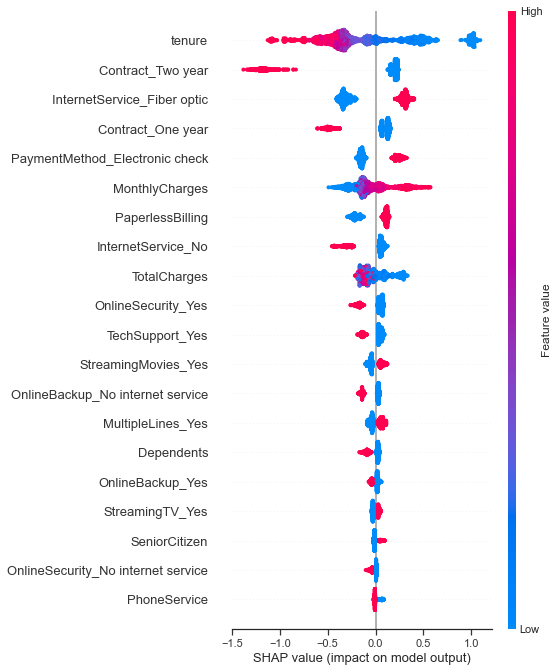

In [36]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values=shap_values, features=X_test)

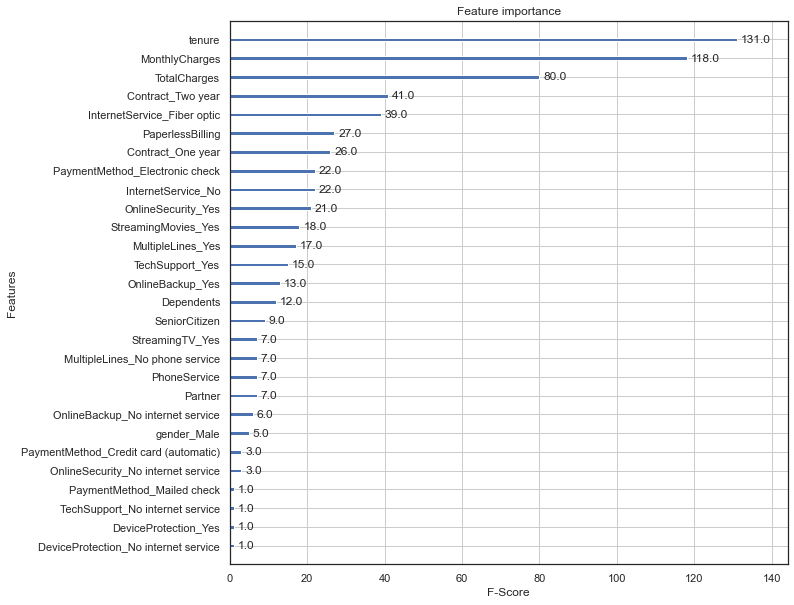

In [37]:
fig, ax0 = plt.subplots(ncols=1,nrows=1,figsize=(10,10))
xgb.plot_importance(xgb_model, importance_type='weight', xlabel='F-Score',ax=ax0)
plt.show()

# 5.Clustering

In [38]:
# Fit the data into a hierarchical clustering algorithm
distance_matrix = linkage(data.drop('Churn',axis=1), 'ward')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16608\2631567895.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


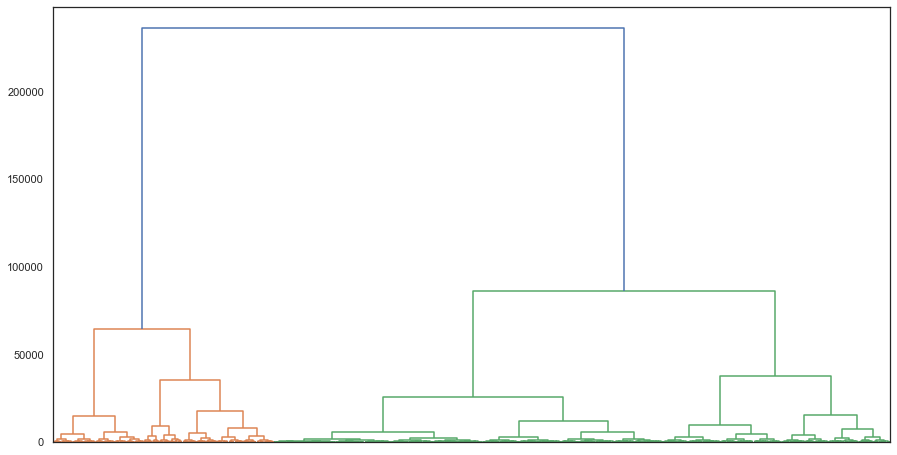

In [39]:
fig, ax = plt.subplots(figsize=(15,8))

# Create a dendrogram
dn = dendrogram(distance_matrix,ax=ax, no_labels=True)
# Display the dendogram
fig.show()

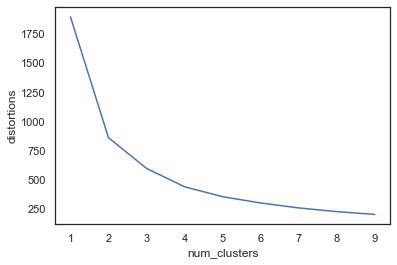

In [40]:
distortions = []
num_clusters = range(1, 10)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(data.drop('Churn',axis=1),i)
    distortions.append(distortion)

# Create a DataFrame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

In [41]:
# Generate cluster centers
cluster_centers, distortion = kmeans(data.drop('Churn',axis=1),2)

# Assign cluster labels
data['cluster_labels'], distortion_list = vq(data.drop('Churn',axis=1),cluster_centers)

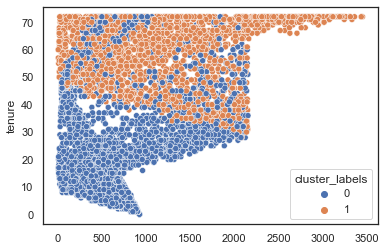

In [42]:
# Plot clusters
sns.scatterplot(x=distortion_list, y='tenure', 
                hue='cluster_labels', data = data)
plt.show()

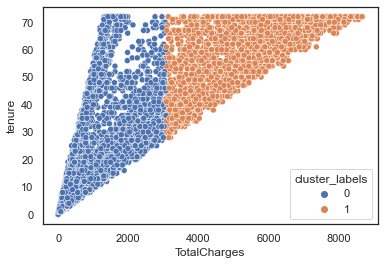

In [43]:
# Plot clusters
sns.scatterplot(x='TotalCharges', y='tenure', 
                hue='cluster_labels', data = data)
plt.show()

In [44]:
data.groupby(['cluster_labels','Churn']).mean()

SeniorCitizen   Partner  Dependents     tenure  \
cluster_labels Churn                                                   
0              0           0.096274  0.437854    0.337705  25.550224   
               1           0.237167  0.302794    0.164392  10.684860   
1              0           0.188565  0.694887    0.357889  59.739417   
               1           0.336364  0.615152    0.221212  51.996970   

                      PhoneService  PaperlessBilling  MonthlyCharges  \
cluster_labels Churn                                                   
0              0          0.876900          0.459314       45.883592   
               1          0.892788          0.734243       69.601852   
1              0          0.945574          0.676196       89.635129   
               1          0.984848          0.818182       97.010909   

                      TotalCharges  gender_Male  \
cluster_labels Churn                              
0              0       1033.945976     0.514158   
               1        775.752567     0.488629   
1              0       5345.988483     0.494777   
               1       5057.708182     0.539394   

                      MultipleLines_No phone service  ...  TechSupport_Yes  \
cluster_labels Churn                                  ...                    
0              0                            0.123100  ...         0.194337   
               1                            0.107212  ...         0.129305   
1              0                            0.054426  ...         0.594832   
               1                            0.015152  ...         0.336364   

                      StreamingTV_No internet service  StreamingTV_Yes  \
cluster_labels Churn                                                     
0              0                             0.421162         0.184501   
               1                             0.073424         0.356725   
1              0                             0.000000         0.700385   
               1                             0.000000         0.803030   

                      StreamingMovies_No internet service  \
cluster_labels Churn                                        
0              0                                 0.421162   
               1                                 0.073424   
1              0                                 0.000000   
               1                                 0.000000   

                      StreamingMovies_Yes  Contract_One year  \
cluster_labels Churn                                           
0              0                 0.185693           0.225931   
               1                 0.361923           0.040936   
1              0                 0.709731           0.301814   
               1                 0.790909           0.312121   

                      Contract_Two year  \
cluster_labels Churn                      
0              0               0.228614   
               1               0.004548   
1              0               0.483782   
               1               0.124242   

                      PaymentMethod_Credit card (automatic)  \
cluster_labels Churn                                          
0              0                                   0.207452   
               1                                   0.105263   
1              0                                   0.326553   
               1                                   0.212121   

                      PaymentMethod_Electronic check  \
cluster_labels Churn                                   
0              0                            0.243815   
               1                            0.582846   
1              0                            0.261682   
               1                            0.527273   

                      PaymentMethod_Mailed check  
cluster_labels Churn                              
0              0                        0.344262  
               1                        0.193632  
1   

In [45]:
data.cluster_labels.value_counts()/data.shape[0]

0    0.694874
1    0.305126
Name: cluster_labels, dtype: float64

## 5.2 Models with Cluster Column 

In [46]:
np.random.seed(123)
features = data.drop(['Churn'],axis=1).reset_index(drop=True)
label = data['Churn'].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.33, random_state=42,stratify=label)

In [47]:
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Male,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,cluster_labels
4109,0,0,0,2,0,1,25.05,56.35,1,1,...,0,0,0,0,0,0,0,1,0,0
1981,0,1,0,58,1,1,102.10,5885.40,0,0,...,0,1,0,1,0,0,1,0,0,1
6102,0,1,0,64,1,1,85.00,5484.40,0,0,...,0,1,0,1,0,1,1,0,0,1
5888,0,1,1,49,1,1,95.60,4783.50,0,0,...,0,1,0,1,0,0,0,1,0,1
2756,0,0,0,1,1,0,20.95,20.95,0,0,...,1,0,1,0,0,0,0,0,1,0


C:\Users\ASUS\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


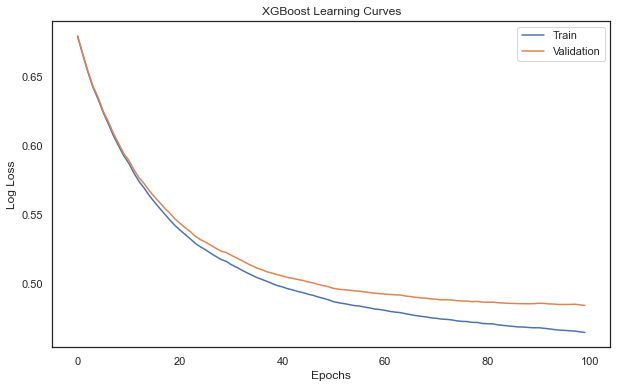

In [48]:
xgb_model = XGBClassifier(
    max_depth=3,            
    min_child_weight=5,     
    subsample=0.8,          
    colsample_bytree=0.6,   
    reg_alpha=0.1,          
    reg_lambda=1.0,         
    n_estimators=100,       
    learning_rate=0.05 ,
    scale_pos_weight=scale_pos_weight
)

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Extract results from evaluation history
results = xgb_model.evals_result()

# Plot learning curves
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.show()

Accuracy train : 0.7453763440860215 F1 Score train : 0.6313823163138231 


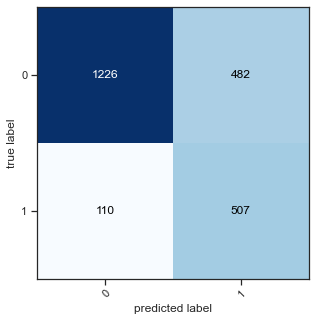

In [49]:
prediction = xgb_model.predict(X_test)
print(f"Accuracy train : {accuracy_score(y_test,prediction)} F1 Score train : {f1_score(y_test, prediction)} ")

result=confusion_matrix(y_test,prediction)
plot_confusion_matrix(conf_mat=result,figsize=(5,5),class_names=np.unique(y_test))
plt.show()